## To DO

- remove CL:0000533 from the hand-annotated data - it's not in the census
- finish internal cell accuracy calculations
- predict better(?) internal cells annotations

In [1]:
import anndata as ad
import torch
import torch.nn as nn
import torch.nn.functional as F

import pronto
import warnings
warnings.filterwarnings("ignore", category=pronto.warnings.ProntoWarning)


import pandas as pd
import numpy as np
import scipy 

import matplotlib.pyplot as plt

import scanpy as sc

import os
import pickle

%matplotlib inline

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
cl = pronto.Ontology.from_obo_library('cl.owl')


In [4]:
ad.__version__

'0.10.3'

In [9]:
sc.__version__

'1.9.3'

## Load the hand annotated data

In [4]:
adata_ann = ad.read_h5ad('multivelo.h5ad') # hand annotated 7th day uninfected HSPC - variable genes only

# hand annotated 7th day uninfected HSPC  - original cellranger output matrix containing all cells and genes
#adata = ad.read_h5ad('filtered_feature_bc_matrix.h5') 
adata_raw = sc.read_10x_h5('filtered_feature_bc_matrix.h5')#,key='matrix')

/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [25]:
adata_ann


AnnData object with n_obs × n_vars = 11605 × 899
    obs: 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'S_score', 'G2M_score', 'phase', 'fractions_u', 'leiden'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'mean', 'std', 'fit_alpha_c', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_sw1', 'fit_t_sw2', 'fit_t_sw3', 'fit_scale_cc', 'fit_rescale_c', 'fit_rescale_u', 'fit_alignment_scaling', 'fit_c0', 'fit_u0', 'fit_s0', 'fit_model', 'fit_direction', 'fit_loss', 'fit_likelihood', 'fit_anchor_min_idx', 'fit_anchor_max_idx', 'velo_s_genes', 'velo_u_genes', 'velo_chrom_genes'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', 'velo_chrom_params', 'velo_s_params', 'velo_u_params'
    obsm: 'X_pca', 'X_

In [52]:
adata_raw

AnnData object with n_obs × n_vars = 14895 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

In [ ]:
# what exactly do I need in terms of meta data?
- GENE ENSEMBL IDs - merged_data.var['gene_ids']
- Cell Type - merged_data.obs['leiden']

## Plot the UMAP

From Chen: I think there's a X_umap field in the h5ad object /nfs/turbo/umms-welchjd/chen/HSPC_3423-MV-2/multivelo.h5ad (adata.obsm['X_umap']). You can plot with sc.pl.umap. If not just let me know. 

In [5]:
umap_object = adata_ann.obsm['X_umap']

/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


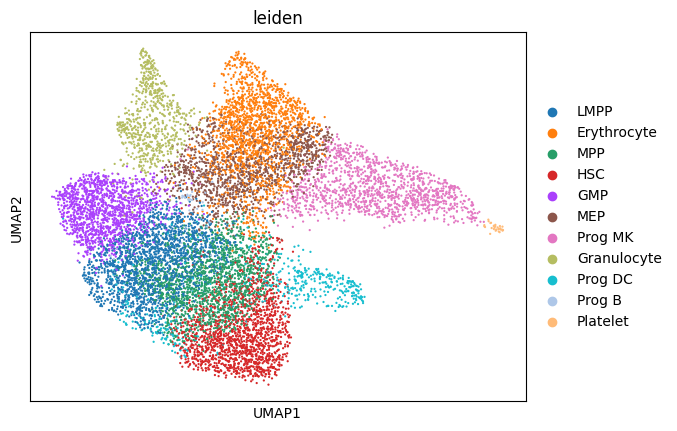

In [65]:
sc.pl.umap(adata_ann,color='leiden')

Add our predicted cell types to the AnnData object to create our own umap plot

In [124]:
# cell IDs
adata_ann.obs['PredictedType'] = predicted_df['PredictedType'].to_list()

# common names
adata_ann.obs['Predicted_Cell_Type'] = predicted_df['PredictedCommonType'].to_list()


In [61]:
adata_ann.obs['PredictedType']

AAACAGCCAAACCTTG-1    CL:0000583
AAACAGCCACCCTCAC-1    CL:0000050
AAACATGCAATCGCAC-1    CL:0000050
AAACATGCACAGCCTG-1    CL:0000050
AAACATGCAGAGGCTA-1    CL:0000583
                         ...    
TTTGTTGGTGTTAAAC-1    CL:0000556
TTTGTTGGTGTTGTGA-1    CL:0000556
TTTGTTGGTTACCTGT-1    CL:0000583
TTTGTTGGTTCCGGGA-1    CL:0000050
TTTGTTGGTTGCCTCA-1    CL:0000583
Name: PredictedType, Length: 11605, dtype: object

/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


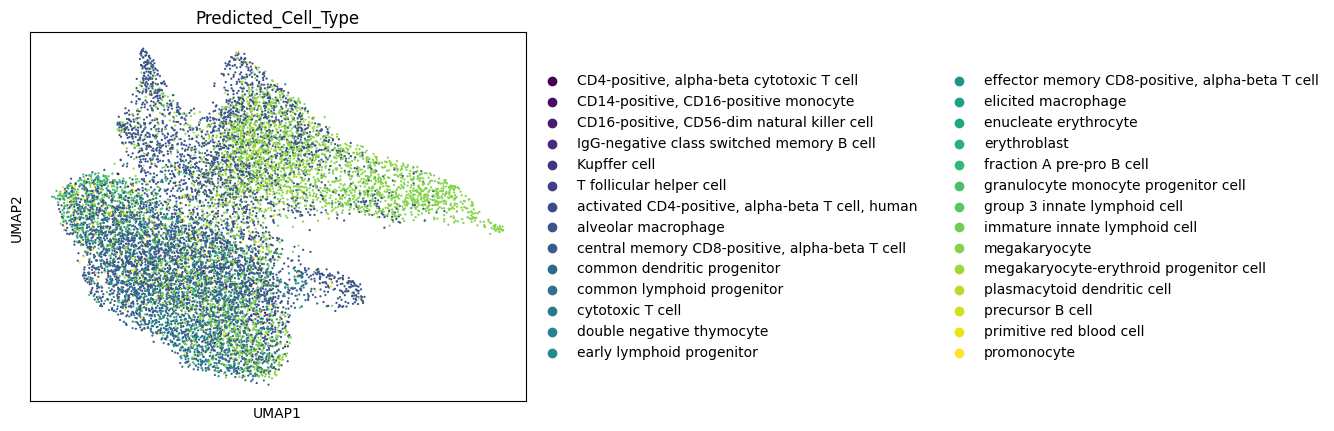

In [127]:
#with plt.rc_context({"figure.figsize": (8, 8), "figure.dpi": (300)}):
#sc.pl.umap(adata_ann,color='Predicted_Cell_Type',palette = 'tab20b')


sc.pl.umap(adata_ann,color='Predicted_Cell_Type',palette = 'viridis')


## Merge the Raw Data File with the Annotated file

In [5]:
def merge_data_files(adata_raw,adata_ann):
    '''
    Function that 
    
    adata_raw : AnnData Object
        original cellranger output matrix containing all cells and genes
        
    adata_ann : AnnData Object
        hand annotated data, variable genes only
    
    '''
    
    # the index of the obs axis of the AnnData objects contains strings
    # that identify each individual cell. 
    # we want to create a new AnnData Object that includes:
    # 1) all gene expressions from adata_raw
    # 2) only the cells in adata_ann
    # 3) the var and obs axes from adata_ann
    
    # get list of cells from the annotated data
    cell_list = adata_ann.obs.index

    # selects the cells in the annotated file from the raw file
    merged_data = adata_raw[cell_list]

    # add the obs axis from the annotated data to the merged data 
    merged_data.obs = adata_ann.obs
    
    return merged_data


In [6]:
merged_data = merge_data_files(adata_raw,adata_ann)

/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/fujoshua/cell_classification/env/lib/python3.10/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [24]:
merged_data

AnnData object with n_obs × n_vars = 11605 × 36601
    obs: 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'S_score', 'G2M_score', 'phase', 'fractions_u', 'leiden', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome'

## Map the annotated cell types to Cell Ontology IDs

What we need are indicies that we can then use to split the data later on. 

In [7]:
merged_data_obs_df = merged_data.obs#['leiden']#.unique().tolist()

In [8]:
merged_data_obs_df

,n_counts,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,initial_size_spliced,initial_size_unspliced,initial_size,S_score,G2M_score,phase,fractions_u,leiden
AAACAGCCAAACCTTG-1,4234.334961,1497,3384.0,0.0,0.0,3384,1563,3384.0,-0.634671,-0.215746,G1,0.308031,Granulocyte
AAACAGCCACCCTCAC-1,4246.441406,1673,3251.0,0.0,0.0,3251,1904,3251.0,0.423275,-0.362225,S,0.301643,Erythrocyte
AAACATGCAATCGCAC-1,4228.449219,1652,3272.0,0.0,0.0,3272,1849,3272.0,-0.801623,-0.463818,G1,0.374815,Erythrocyte
AAACATGCACAGCCTG-1,4223.146973,3637,10265.0,0.0,0.0,10265,3769,10265.0,0.408826,0.540197,G2M,0.290607,Prog MK
AAACATGCAGAGGCTA-1,4230.780762,1572,3526.0,0.0,0.0,3526,1792,3526.0,0.400493,-0.121910,S,0.318393,MPP
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGTTGGTGTTAAAC-1,4194.219238,1642,3244.0,0.0,0.0,3244,1723,3244.0,0.000000,-0.201697,S,0.340409,HSC
TTTGTTGGTGTTGTGA-1,4216.825195,2306,5480.0,0.0,0.0,5480,2348,5480.0,-0.291098,-0.117548,G1,0.345615,MEP
TTTGTTGGTTACCTGT-1,4240.065430,1664,3310.0,0.0,0.0,3310,1678,3310.0,0.000000,0.155516,G2M,0.304211,MEP
TTTGTTGGTTCCGGGA-1,4253.901855,2193,5188.0,0.0,0.0,5188,1870,5188.0,0.296031,0.044591,S,0.322785,Erythrocyte


In [9]:
# double check at least PROG DC, this was the primary one that was
# unclear in identifying. CL_0002009 (macrophage dendritic cell progenitor) - confirmed with Welch 29 Nov

# all of these values vall under Hematopoietic cell
# 553 and 1012 not in cell census

mapping_dict_cell_types = {'Granulocyte' : 'CL:0000094',
                'Erythrocyte' : 'CL:0000232',
                'Prog MK' : 'CL:0000553',
                'MPP' : 'CL:0000837',
                'GMP' : 'CL:0000557',
                'HSC' : 'CL:0000037',
                'LMPP' : 'CL:0000936',
                'MEP' : 'CL:0000050',
                'Prog DC' : 'CL:0002009',
                'Platelet' : 'CL:0000233',
                'Prog B' : 'CL:0000826'}    
    

merged_data_obs_df['cell_type'] = merged_data_obs_df['leiden'].map(mapping_dict_cell_types)

In [32]:
'CL:0002009' in internal_values #or leaf_values

False

In [21]:
leaf_targets

['CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:00005

In [10]:
cell_type_list = merged_data_obs_df['cell_type'].to_list()

# loop through the list and save the index values

leaf_value_list = ['CL:0000936','CL:0000557'] #557 is an internal value, but census doesn't have any children
internal_value_list = ['CL:0000094','CL:0000232','CL:0000553','CL:0000837','CL:0000037',
                      'CL:0000050','CL:0001012','CL:0000233','CL:0000826']

leaf_index_values = []
internal_index_values = []

for itr in range(len(cell_type_list)):
    if cell_type_list[itr] in leaf_value_list:
        leaf_index_values.append(itr)
    else:
        internal_index_values.append(itr)
       
# get the list of targets for both leafs and internal values
leaf_targets = [cell_type_list[i] for i in leaf_index_values] 
internal_targets = [cell_type_list[i] for i in internal_index_values]

In [49]:
leaf_targets.count('CL:0000936')

1816

In [41]:
leaf_targets.count('CL:0000557')

1344

In [71]:
leaf_targets

['CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:00009

This data has 11605 cells with 899 genes measured for each. 

### Obs DataFrame

In [10]:
df['cell_type'].value_counts()

cell_type
CL:0000936    1816
CL:0000232    1606
CL:0000837    1605
CL:0000037    1529
CL:0000557    1344
CL:0000050    1246
CL:0000553    1240
CL:0000094     661
CL:0001012     492
CL:0000826      36
CL:0000233      30
Name: count, dtype: int64

In [11]:
df.shape

(11605, 14)

936 and 233 are the only leaf nodes, so that amounts to 1846 cells, which is 16% of the total sample.

## Load and Model Validation Data for testing of code

In [3]:
os.chdir('/scratch/welchjd_root/welchjd99/fujoshua')
X_val_17Nov = torch.load('X_val_17Nov.pt',map_location=torch.device('cpu'))
y_val_17Nov = torch.load('y_val_17Nov.pt',map_location=torch.device('cpu'))

In [4]:
y_val_17Nov


tensor([-9984,     0,     1,  ...,    21,    27,    18])

In [8]:
external_outputs = clf(X_val_17Nov.float()) # might need to change to X_train.float()


In [13]:
external_outputs.shape

torch.Size([94469, 52])

Split the data into leaf and internal values

In [44]:
leaf_index_values = []
internal_index_values = []

for itr in range(len(y_val_17Nov)):
    #print(y_val_17Nov[itr].item())
    if y_val_17Nov[itr] == 19 or y_val_17Nov[itr] == 15:
        leaf_index_values.append(itr)
    else:
        internal_index_values.append(itr)


In [43]:
leaf_values_in_hand_data = 'CL:0000936','CL:0000557'
print(mapping_dict['CL:0000936'],mapping_dict['CL:0000557'])


19 15


In [45]:

leaf_external_outputs,internal_external_outputs = split_data(external_outputs, 
                                                             leaf_index_values,internal_index_values)

y_val_leaf_external_outputs = y_val_17Nov[leaf_index_values]
    
y_val_internal_external_outputs = y_val_17Nov[internal_index_values]



In [46]:
y_val_17Nov.shape

torch.Size([94469])

In [47]:
y_val_leaf_external_outputs.shape

torch.Size([55])

In [48]:
# check accuracy by hand

__, predicted_leaf_external_outputs = leaf_external_outputs.max(dim=1)


# encode leaf target values using the same method 
#target_value_list = list(map(mapping_dict.get,leaf_targets))

# convert to a tensor
#target_values_tensor = torch.LongTensor(target_value_list)

# calculate the accuracy
correct_leaf = (predicted_leaf_external_outputs == y_val_leaf_external_outputs).sum().item()
#print(torch.sum(target_value_list == target_values_tensor))

accuracy_leaf = (correct_leaf / predicted_leaf_external_outputs.shape[0] * 100.)
print(accuracy_leaf)



89.0909090909091


The data from Chen has two cell types that are listed as leaf values in the Cell Ontology that are also included in the Census Data. These are CL:0000936 and CL:0000557. These cell types are not well-represented in the Census data, with only 230 cells in the training data and 55 cells in the validation data. Though the accuracy of the validation set for these two cells types is ~89%. But when I test Chen's data against my model, I'm getting a leaf accuracy of ~21%. I'm certain enough in this value to share, though I'm still double checking a few things to make sure it's correct. But obviously that's not a great encouragement/evidence at this point. 

I'll compare that percentage to the non-heirarchical model today. I suppose it might still show some improvement?




## Load the PyTorch Model

In [11]:
input_dim = 19966 # need to check if we mean 19966??????

# number of neurons for hidden layers
hidden_layer_1 = 256
hidden_layer_2 = 128

# number of classes (unique of y)
output_dim = 85

In [12]:
class Network2(nn.Module):
    def __init__(self):
        super(Network2, self).__init__()
        self.linear1 = nn.Linear(input_dim,hidden_layer_1)
        self.linear2 = nn.Linear(hidden_layer_1,hidden_layer_2)
        self.linear3 = nn.Linear(hidden_layer_2,output_dim)
        self.bn1 = nn.BatchNorm1d(hidden_layer_1)
        self.bn2 = nn.BatchNorm1d(hidden_layer_2)
        
    def forward(self,x):
        x = self.linear1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.softmax(x,dim=1)
        return x

In [13]:
clf = Network2()

# use map_location if model was trained on GPU but is being loaded on CPU
os.chdir('/home/fujoshua/cell_classification/model_outputs/')

#model = torch.load('30_Oct_best_model',map_location=torch.device('cpu'))
clf.load_state_dict(torch.load('1_Dec_best_model',map_location=torch.device('cpu')))
# set model to eval mode
clf.eval()


Network2(
  (linear1): Linear(in_features=19966, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=85, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## Map the genes in the training data to the genes in the hand-annotated data

The hand-annotated data set needs to be structured the same as the Cell_Census data, particularly with respect to the order of the genes in the dataframe. We can use ENSEMBL GENE IDs to transform the hand-annotated data to match the cell_census data

- Gene information in the training data from Cell_Census is stored under var feature_id
- Gene information in the hand-annotated data is stored under var Accession

In [14]:
# get the training data
#train_adata = ad.read_h5ad('small_1044_900') # 42000 cells, 60k genes, including noncoding ones


os.chdir('/scratch/welchjd_root/welchjd99/fujoshua')
train_adata = ad.read_h5ad('24Oct_hematopoietic_cells_p2') # 472k cells, 20k genes, part of the full hema data set



In [15]:
train_adata

AnnData object with n_obs × n_vars = 472343 × 19966
    obs: 'cell_type_ontology_term_id', 'assay', 'is_primary_data'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length'

In [19]:
train_adata.var['feature_name']

0                A1BG
1                A1CF
2                 A2M
3               A2ML1
4             A3GALT2
             ...     
19961      AP000326.5
19962    RP11-442J1.2
19963     GS2-740I5.1
19964      AC001226.8
19965    RP5-973N23.5
Name: feature_name, Length: 19966, dtype: object

In [21]:
# create a dictionary where each key is a gene in train_gene and
# the value is the index in the list

train_gene_dict = {k: v for v, k in enumerate(train_genes)}

In [22]:
train_gene_dict

{'ENSG00000228463': 0,
 'ENSG00000225880': 1,
 'ENSG00000230368': 2,
 'ENSG00000187634': 3,
 'ENSG00000188976': 4,
 'ENSG00000187961': 5,
 'ENSG00000187583': 6,
 'ENSG00000187642': 7,
 'ENSG00000188290': 8,
 'ENSG00000187608': 9,
 'ENSG00000188157': 10,
 'ENSG00000131591': 11,
 'ENSG00000162571': 12,
 'ENSG00000186891': 13,
 'ENSG00000186827': 14,
 'ENSG00000078808': 15,
 'ENSG00000176022': 16,
 'ENSG00000184163': 17,
 'ENSG00000160087': 18,
 'ENSG00000162572': 19,
 'ENSG00000131584': 20,
 'ENSG00000169972': 21,
 'ENSG00000127054': 22,
 'ENSG00000224051': 23,
 'ENSG00000107404': 24,
 'ENSG00000162576': 25,
 'ENSG00000175756': 26,
 'ENSG00000221978': 27,
 'ENSG00000242485': 28,
 'ENSG00000235098': 29,
 'ENSG00000179403': 30,
 'ENSG00000215915': 31,
 'ENSG00000160072': 32,
 'ENSG00000197785': 33,
 'ENSG00000160075': 34,
 'ENSG00000215014': 35,
 'ENSG00000228594': 36,
 'ENSG00000197530': 37,
 'ENSG00000189409': 38,
 'ENSG00000248333': 39,
 'ENSG00000189339': 40,
 'ENSG00000008128': 41,
 '

### Build AnnData Object that matches the CellCensus Structure

We need a function that will transform an external AnnData object to match the structure of the CellCensus data. Most importantly, we need to match the gene order.

In [15]:
def build_data_object(external_adata,external_adata_gene_id,train_adata,train_gene_id):
    '''
    This function takes an external AnnData object and transforms it, as needed, to 
    match the structure of Cell Census AnnData objects. 
    
    external_adata : AnnData object
        data that you want to transform
        
    external_adata_gene_id : string
        string with the var name of the EMSEMBL genes
        
    train_adata : AnnData object
        this object contains the data format we want to match
    
    train_gene_id : string
        string with the var name of the ENSEMBL genes
    
    '''    
    
    # convert the new_adata object (the one to be
    # transformed) to a DataFrame
    external_adata_df = external_adata.to_df(layer=None)
    
    # change the column names of this dataframe 
    # to the ENSEMBL Gene IDs
    # get list of genes from the var part of the adata object
    # these are stored in the same order as the HGNC names, so we
    # can just replace the column names
    # can use BioMart to double check mappings
    # https://useast.ensembl.org/Homo_sapiens/Gene/Summary?g=ENSG00000111644;r=12:6638075-6647433
    
    
    external_listofensemblIDs = external_adata.var[external_adata_gene_id].to_list()

    external_adata_df.columns = external_listofensemblIDs

    
    # get the list of genes in the traing object
    train_genes = train_adata.var[train_gene_id].to_list()
    
    ### create a dictionary where each key is a gene in census_gene and
    ### the value is the index in the list

    ###train_gene_dict = {k: v for v, k in enumerate(train_genes)}
    ###print(list(train_gene_dict.keys())[list(train_gene_dict.values()).index('ENSG00000237940')])  # Prints george


    # we have the external df with ENSEMBL #s for columns,
    # now, we need to create a new dataset, where the column order comes from
    # the training data, IF the column name is in adata_df, use that, else input 0s
    
    # get list of all genes in train_genes NOT IN external_listofensemblIDs
    missing_genes = [x for x in train_genes if x not in external_listofensemblIDs]

    
    # there are extra genes in external_listofensemblIDs that are not in train_genes
    # get a list of those to remove
    extra_genes = [x for x in external_listofensemblIDs if x not in train_genes]  

    
    external_adata_df.drop(columns=extra_genes,inplace=True)

    # create an new Dataframe with genes from missing_genes, expression values
    # of 0 
    genes_to_add_df = pd.DataFrame(0,index=external_adata_df.index,columns=missing_genes)

    # add these genes to the existing DataFrame, with expression values of 0
    #adata_df[missing_genes] = 0
    combined_df = pd.concat([external_adata_df,genes_to_add_df],axis=1)
    
    # take combined_df and re-order the columns to match the
    # order from census_adata
    transformed_df = combined_df[train_genes]
    #print(transformed_df.shape)
    
    # don't need to do this at the moment, saving the idea for later
    # convert to AnnData object
    # from https://stackoverflow.com/questions/65117950/how-do-i-create-anndata-object-from-a-pandas-data-frame-count-matrix
    #new_adata = ad.AnnData(X = transformed_df.values,
    #                    obs = transformed_df.index,
    #                    var = transformed_df.columns)

    return(transformed_df)
    
    

'ENSG00000121410', 'ENSG00000148584', 'ENSG00000175899'

In [16]:
train_gene_id = 'feature_id'

external_adata_gene_id = 'gene_ids'


external_expanded_df = build_data_object(merged_data,external_adata_gene_id,train_adata,train_gene_id)


In [17]:
external_expanded_df.head()

,ENSG00000121410,ENSG00000148584,ENSG00000175899,ENSG00000166535,ENSG00000184389,ENSG00000128274,ENSG00000118017,ENSG00000094914,ENSG00000081760,ENSG00000114771,...,ENSG00000288695,ENSG00000288699,ENSG00000288706,ENSG00000288708,ENSG00000288710,ENSG00000288711,ENSG00000288712,ENSG00000288715,ENSG00000288716,ENSG00000288721
AAACAGCCAAACCTTG-1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
AAACAGCCACCCTCAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
AAACATGCAATCGCAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
AAACATGCACAGCCTG-1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
AAACATGCAGAGGCTA-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
external_expanded_df.shape


(11605, 19966)

In [16]:
external_expanded_df.sum(axis=0)#.value_counts()

ENSG00000121410    2501.0
ENSG00000148584       1.0
ENSG00000175899    3155.0
ENSG00000166535      60.0
ENSG00000184389      25.0
                    ...  
ENSG00000288711       0.0
ENSG00000288712       0.0
ENSG00000288715       0.0
ENSG00000288716       0.0
ENSG00000288721       0.0
Length: 19966, dtype: float64

In [19]:
merged_data.var['gene_ids']['LINC01238']

LINC01238    ENSG00000237940
LINC01238    ENSG00000261186
Name: gene_ids, dtype: object

## Preprocess Data for Modeling

We'll follow the same process of preprocessing the data before we input it into the model. First, we need to convert the pandas dataframe to a scipy sparse CSR matrix. Then, we transform the data with log(1+data). Finally, we convert the data to PyTorch Tensors.

In [20]:
def preprocess_data(external_df):
    '''
    This function takes the input Pandas Dataframe and then:
    1) converts to a scipy sparse CSR matrix
    2) transforms the data with log(1+data)
    3) converts the data to pytorch tensors
    
    Parameters
    ----------
    external_df : pandas dataframe
        
        
    Returns
    -------
    x_data : SciPy Matrix
        scipy sparse CSR matrix
    
    '''
    
    # convert the data to a scipy sparse CSR matrix
    x_data = scipy.sparse.csr_matrix(external_df.values)
    
    # transform the data
    # np.log takes the natural log
    x_data.data = np.log(1+ x_data.data)

    # convert x_data to a pytorch tensor, starting
    # by converting it to COO formating
    # following https://stackoverflow.com/questions/50665141/converting-a-scipy-coo-matrix-to-pytorch-sparse-tensor
    # 
    x_data_coo = x_data.tocoo()

    # for some reason, doing this at once loosed 70 vlaues, so we'll
    # do it in pieces instead.
    #x_data_tensor = torch.sparse.FloatTensor(torch.LongTensor(np.vstack((x_data_coo.row,x_data_coo.col))),
    #                              torch.FloatTensor(x_data_coo.data))
    
    values = x_data_coo.data
    indices = np.vstack((x_data_coo.row, x_data_coo.col))

    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = x_data_coo.shape

    x_data_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))    
    
    #print(x_data_tensor.shape)
    
    # move to device
    #x_data_tensor = x_data_tensor.to(device)

    return x_data_tensor

In [21]:
formatted_data = preprocess_data(external_expanded_df)


In [21]:
19966-19896

70

In [42]:
formatted_data

tensor(indices=tensor([[    0,     0,     0,  ..., 11604, 11604, 11604],
                       [    2,    26,    53,  ..., 18829, 18839, 19130]]),
       values=tensor([1.0986, 0.6931, 0.6931,  ..., 0.6931, 0.6931, 0.6931]),
       size=(11605, 19966), nnz=40481856, layout=torch.sparse_coo)

In [43]:
external_expanded_df.shape

(11605, 19966)

## Run the data through the model

In [22]:
external_outputs = clf(formatted_data.float()) # might need to change to X_train.float()


In [20]:
external_outputs

tensor([[3.4109e-01, 2.9599e-03, 3.7882e-02,  ..., 2.4208e-03, 2.1746e-03,
         2.0435e-03],
        [8.1442e-03, 4.1980e-03, 2.6317e-03,  ..., 7.1323e-04, 6.8925e-04,
         7.1886e-04],
        [5.0874e-02, 4.1077e-03, 3.0669e-03,  ..., 1.8077e-03, 1.1431e-03,
         8.9748e-04],
        ...,
        [8.5578e-01, 3.3353e-03, 8.0262e-03,  ..., 1.2232e-03, 6.3361e-04,
         8.4421e-04],
        [2.3135e-01, 1.4750e-02, 9.2650e-03,  ..., 2.0007e-03, 1.2215e-03,
         5.2859e-03],
        [4.4644e-01, 6.1004e-03, 1.4103e-02,  ..., 9.4694e-03, 1.1426e-02,
         6.2960e-03]], grad_fn=<SoftmaxBackward0>)

In [42]:
# get the predictions
__, predicted_external_outputs = external_outputs.max(dim=1)            


In [48]:
predicted_external_outputs.unique(return_counts=True)

(tensor([ 0,  1,  2,  4,  5,  6,  7,  8, 10, 11, 12, 15, 16, 19, 21, 22, 23, 28,
         30, 34, 35, 36, 37, 40, 41, 45, 47, 49]),
 tensor([5031,    8,    4,    9,  893,    8,   17, 1471,   32,   15,  200,  589,
         2217,  843,   38,    8,   46,    1,   63,   24,    1,    7,   14,    1,
            9,   22,    1,   33]))

In [119]:
# convert the predicted outputs to a pandas series

predicted_df = pd.DataFrame(predicted_external_outputs.numpy())

# add a column with mapping to Cell Types

# invert the dictionary
inv_mapping_dict = {v: k for k, v in mapping_dict.items()}

predicted_df['PredictedType'] = predicted_df[0].map(inv_mapping_dict)

# create a dictionary with the common names
common_name_dict = {'CL:0000583' : 'alveolar macrophage',
                   'CL:0000050' : 'megakaryocyte-erythroid progenitor cell',
                   'CL:0000556' : 'megakaryocyte',
                   'CL:0000091' : 'Kupffer cell',
                   'CL:0000557' : 'granulocyte monocyte progenitor cell',
                   'CL:0000051' : 'common lymphoid progenitor',
                   'CL:0000559' : 'promonocyte',
                   'CL:0000936' : 'early lymphoid progenitor',
                   'CL:0001082' : 'immature innate lymphoid cell',
                   'CL:0000907' : 'central memory CD8-positive, alpha-beta T cell',
                   'CL:0001071' : 'group 3 innate lymphoid cell',
                   'CL:0001029' : 'common dendritic progenitor',
                   'CL:0002397' : 'CD14-positive, CD16-positive monocyte',
                   'CL:0002355' : 'primitive red blood cell',
                   'CL:0001043' : 'activated CD4-positive, alpha-beta T cell, human',
                   'CL:0000817' : 'precursor B cell',
                   'CL:0002045' : 'fraction A pre-pro B cell',
                   'CL:0000861' : 'elicited macrophage',
                   'CL:0001062' : 'effector memory CD8-positive, alpha-beta T cell',
                   'CL:0000595' : 'enucleate erythrocyte',
                   'CL:0002489' : 'double negative thymocyte',
                   'CL:0002038' : 'T follicular helper cell',
                   'CL:0000910' : 'cytotoxic T cell',
                   'CL:0000765' : 'erythroblast',
                   'CL:0001058' : 'plasmacytoid dendritic cell',
                   'CL:0000934' : 'CD4-positive, alpha-beta cytotoxic T cell',
                   'CL:0002117' : 'IgG-negative class switched memory B cell',
                   'CL:0000939' : 'CD16-positive, CD56-dim natural killer cell'}

predicted_df['PredictedCommonType'] = predicted_df['PredictedType'].map(common_name_dict)



In [104]:
predicted_df

,0,PredictedType,PredictedCommonType
0,0,CL:0000583,alveolar macrophage
1,8,CL:0000050,megakaryocyte-erythroid progenitor cell
2,8,CL:0000050,megakaryocyte-erythroid progenitor cell
3,8,CL:0000050,megakaryocyte-erythroid progenitor cell
4,0,CL:0000583,alveolar macrophage
...,...,...,...
11600,16,CL:0000556,megakaryocyte
11601,16,CL:0000556,megakaryocyte
11602,0,CL:0000583,alveolar macrophage
11603,8,CL:0000050,megakaryocyte-erythroid progenitor cell


In [102]:
cl['CL:0000939'].name

'CD16-positive, CD56-dim natural killer cell, human'

In [73]:
predicted_df['PredictedType'].unique()

array(['CL:0000583', 'CL:0000050', 'CL:0000556', 'CL:0000091',
       'CL:0000557', 'CL:0000051', 'CL:0000559', 'CL:0000936',
       'CL:0001082', 'CL:0000907', 'CL:0001071', 'CL:0001029',
       'CL:0002397', 'CL:0002355', 'CL:0001043', 'CL:0000817',
       'CL:0002045', 'CL:0000861', 'CL:0001062', 'CL:0000595',
       'CL:0002489', 'CL:0002038', 'CL:0000910', 'CL:0000765',
       'CL:0001058', 'CL:0000934', 'CL:0002117', 'CL:0000939'],
      dtype=object)

In [54]:
predicted_df['PredictedType']

0        CL:0000583
1        CL:0000050
2        CL:0000050
3        CL:0000050
4        CL:0000583
            ...    
11600    CL:0000556
11601    CL:0000556
11602    CL:0000583
11603    CL:0000050
11604    CL:0000583
Name: PredictedType, Length: 11605, dtype: object

In [49]:
external_outputs.shape

torch.Size([11605, 52])

## Compare the predicted outputs to the hand-annotated data.

We'll want to split the dataset into predicted leaf and internal nodes. Then we'll calculate the leaf accuracy and internal nodes accuracy separately. Finally, for the internal nodes, we'll want to check if we can make a 'better' prediction.

In [24]:
def split_data(external_outputs, leaf_index_values,internal_index_values):
    '''
    
    
    '''
    
    leaf_external_outputs = external_outputs[leaf_index_values,:]
    
    internal_external_outputs = external_outputs[internal_index_values,:]
    
    return(leaf_external_outputs,internal_external_outputs)
    
    
    

In [25]:
leaf_external_outputs,internal_external_outputs = split_data(external_outputs, 
                                                             leaf_index_values,internal_index_values)



In [42]:
leaf_values

['CL:0000583',
 'CL:0000861',
 'CL:0000765',
 'CL:0000903',
 'CL:0000910',
 'CL:0000051',
 'CL:0000817',
 'CL:0001029',
 'CL:0000050',
 'CL:0000547',
 'CL:0002355',
 'CL:0002045',
 'CL:0000559',
 'CL:0000816',
 'CL:0000836',
 'CL:0000557',
 'CL:0000556',
 'CL:0000092',
 'CL:0000938',
 'CL:0000936',
 'CL:0000771',
 'CL:0001082',
 'CL:0002489',
 'CL:0001071',
 'CL:0002425',
 'CL:0000915',
 'CL:0000904',
 'CL:0002396',
 'CL:0000934',
 'CL:0000940',
 'CL:0000907',
 'CL:0002677',
 'CL:0002678',
 'CL:0001057',
 'CL:0000091',
 'CL:0000939',
 'CL:0002038',
 'CL:0001062',
 'CL:0000844',
 'CL:0000979',
 'CL:0002117',
 'CL:0000595',
 'CL:0000810',
 'CL:0000811',
 'CL:0002057',
 'CL:0002397',
 'CL:0000800',
 'CL:0001058',
 'CL:0000818',
 'CL:0001043',
 'CL:0001049',
 'CL:0000776']

In [29]:
# mapping dict comes from cell_classification, but I'll type it in now

#mapping_dict_encoding = {'CL:0000936' : 19, 'CL:0000557' : 15}

os.chdir('/home/fujoshua/cell_classification/model_outputs')

#ontology_leaf_df = pd.read_csv('ontology_leaf_df_1Dec.csv',index_col=0)
#ontology_df

with open("leaf_values_1Dec", "rb") as fp:   # Unpickling
    leaf_values = pickle.load(fp)
    
with open("internal_values_1Dec", "rb") as fp:   # Unpickling
    internal_values = pickle.load(fp)

mapping_dict_df = pd.read_csv('mapping_dict_df_1Dec.csv',index_col=0)
mapping_dict = mapping_dict_df.T.to_dict('list')

# get rid of the list formating for the values
for key, value in mapping_dict.items():
    mapping_dict[key] = value[0]

## Pick Single cluster of cells to investigate probabilities

In [69]:
leaf_targets

['CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:00005

In [73]:
#get index values of single cell id
celltype_index_values = []

for itr in range(len(internal_targets)):
    if internal_targets[itr] == 'CL:0000050':
        celltype_index_values.append(itr)
        
# select only those values from the outputs

celltype_external_outputs = internal_external_outputs[celltype_index_values,:]
celltype_targets = [internal_targets[i] for i in celltype_index_values]



In [74]:
celltype_external_outputs.mean(dim=0)

tensor([8.6997e-04, 1.2967e-03, 4.2749e-03, 1.2740e-02, 2.1210e-02, 1.6932e-03,
        7.8871e-04, 3.9928e-04, 7.4958e-04, 3.4111e-04, 8.9301e-04, 1.5634e-03,
        1.6904e-03, 1.1262e-03, 2.6740e-03, 1.3679e-01, 8.4674e-02, 2.5660e-03,
        6.2336e-03, 2.0472e-03, 1.5291e-03, 1.4720e-03, 1.7175e-02, 1.1729e-02,
        2.7685e-03, 1.3965e-03, 9.0862e-04, 2.7040e-04, 7.4115e-04, 3.1300e-03,
        1.2029e-03, 1.0883e-03, 4.0760e-04, 3.7500e-03, 9.7796e-04, 1.0077e-03,
        4.2372e-04, 5.7280e-02, 1.6007e-03, 2.0562e-03, 4.3081e-04, 2.1368e-02,
        2.4587e-03, 3.0085e-03, 5.1297e-01, 1.7157e-03, 2.3377e-03, 2.2673e-03,
        2.6130e-03, 6.6425e-04, 7.1587e-04, 1.5444e-03, 5.6934e-04, 9.5848e-04,
        6.4571e-04, 9.4727e-04, 1.6566e-03, 1.1090e-03, 2.8313e-04, 4.4940e-04,
        3.3467e-03, 7.0443e-04, 1.7607e-03, 3.7036e-04, 7.1965e-04, 6.3834e-04,
        1.0357e-03, 3.4189e-03, 2.2201e-03, 1.0658e-03, 4.6678e-03, 6.5201e-04,
        1.4898e-03, 1.7103e-03, 9.1588e-

In [168]:
celltype_external_outputs.mean(dim=0)[66]

tensor(0.0010, grad_fn=<SelectBackward0>)

In [167]:
mapping_dict['CL:0001057']

66

In [201]:
celltype_external_outputs.mean(dim=0)[mapping_dict['CL:0001050']]

tensor(0.0028, grad_fn=<SelectBackward0>)

In [207]:
list1 = ['CL:0002425',
 'CL:0000559',
 'CL:0000894',
 'CL:0001029',
 'CL:0000936',
 'CL:0002045']

prob = 0
for x in list1:
    prob += celltype_external_outputs.mean(dim=0)[mapping_dict['CL:0001050']].detach()
    
print(prob)

tensor(0.0166)


In [202]:
# under myeloid
#.0010 + .0033 + .0034 + .0023 + .0026 + .0172 + .0030 + .0009 + .0063 + .0027 + .0043

#under blood cell
#.0172

# under leukocyte
.0010 + .0009 + .0004 + .0009 + .0015 + .0027 + .0004 + .0022 + .0033 + .0003 + .0004 + .0004 + .0020 + .0021 + .0006 + .0117 + .0007 + .0008 + .0011 + .0010 + .0050 + .0063 + .0009 + .0018 + .0043 + .0047 + .0003 + .0034 + .0037 + .0007 + .0009 + .0003 + .0028

0.06949999999999999

In [141]:
mapping_dict.keys()

dict_keys(['CL:0000235', 'CL:0000084', 'CL:0002343', 'CL:0000623', 'CL:0000815', 'CL:0001078', 'CL:3000001', 'CL:0000236', 'CL:0000786', 'CL:0000451', 'CL:0000094', 'CL:0000129', 'CL:0000738', 'CL:0000878', 'CL:0000097', 'CL:0000763', 'CL:0000542', 'CL:0000972', 'CL:0000788', 'CL:0000985', 'CL:0000987', 'CL:0000970', 'CL:0000913', 'CL:0000798', 'CL:0000814', 'CL:0000492', 'CL:0000624', 'CL:0000909', 'CL:0000896', 'CL:0000906', 'CL:0000905', 'CL:0000890', 'CL:0000990', 'CL:0000860', 'CL:0000875', 'CL:0000782', 'CL:0000784', 'CL:0000775', 'CL:0000863', 'CL:0000576', 'CL:0000767', 'CL:0000625', 'CL:0002399', 'CL:0000037', 'CL:0001065', 'CL:0000787', 'CL:0000232', 'CL:0000038', 'CL:0000049', 'CL:0000809', 'CL:0000897', 'CL:0000900', 'CL:0000895', 'CL:0000980', 'CL:0000233', 'CL:0000764', 'CL:0001044', 'CL:0001050', 'CL:0002393', 'CL:0002394', 'CL:2000055', 'CL:0000908', 'CL:0000921', 'CL:0000841', 'CL:0000794', 'CL:0000453', 'CL:0000807', 'CL:0000894', 'CL:0000808', 'CL:0000823', 'CL:00008

In [37]:
len(celltype_targets)

1816

## Check Leaf Predictions


In [37]:
def check_leaf_predictions(leaf_external_outputs, leaf_target_values,mapping_dict):
    '''
    Function to calculate the accuracy of leaf node predictions
    
    Parameters
    ----------
    leaf_external_outputs : tensor
        PyTorch tensor of shape [a,b] where a = number of cells and b = number of target leafs
        This tensor is the result of the classification in the neural network
                
    leaf_target_values : list
        list of target Cell Ontology types. Length = a. This list is used with the mapping_dict
        to encode the targets
        
    mapping_dict : dictionary
        dictionary for encoding Cell Ontology values 

    Outputs
    --------
    accuracy_leaf : float
        total accuracy 
    
    '''
    
    # get the predictions for the leaf external outputs
    
    # get the predictions
    __, predicted_leaf_external_outputs = leaf_external_outputs.max(dim=1)
    
    
    # encode leaf target values using the same method 
    target_value_list = list(map(mapping_dict.get,leaf_target_values))
    
    # convert to a tensor
    target_values_tensor = torch.LongTensor(target_value_list)
    
    # calculate the accuracy
    correct_leaf = (predicted_leaf_external_outputs == target_values_tensor).sum().item()
    #print(torch.sum(target_value_list == target_values_tensor))

    accuracy_leaf = (correct_leaf / predicted_leaf_external_outputs.shape[0] * 100.)
    print(accuracy_leaf)
    
    return(accuracy_leaf)
    
    

In [26]:
accuracy_leaf = check_leaf_predictions(leaf_external_outputs,leaf_targets,mapping_dict)

21.10759493670886


In [53]:
def update_ontology_df(ontology_df,nodes_to_add):
    '''
    Takes an existing ontology dataframe and adds rows for each value in nodes_to_add.
    Useful for when external datasets have internal nodes that we not in the original training
    dataset
    
    TO ADD: if the values to add are all 0, we probably don't want to add this row. Confirm that,
    then add a check if needed.
    
    outline:
    Get list of columns (leaf nodes)
    For each value in nodes_to_add:
    - get list of leaf values from Cell Ontology
    - initialize list of length leaf_nodes with all 0s.
    - update list with 1 if appropriate
    - add row to dataframe
    
    '''
    
    # get list of leaf nodes, these are the columns values
    leaf_nodes_from_df = ontology_df.columns.to_list()
    
    #print(leaf_nodes_from_df)
    
    # loop through nodes_to_add and add row to dataframe
    for cell_id in nodes_to_add:
        # get all values
        #print(cell_id)
        children_nodes = []
        for term in cl[cell_id].subclasses(distance=None,with_self=False).to_set():
            if term.id in leaf_nodes_from_df:
                children_nodes.append(term.id)

        # initialze list that has all zero values
        new_row_values = [0] * len(leaf_nodes_from_df)
        #print(new_row_values)
        
        #print(children_nodes)
        #print(new_row_values)

        #get index of values in 
        for x in children_nodes:
            index_to_update = leaf_nodes_from_df.index(x)
            new_row_values[index_to_update] = 1.
        #print(new_row_values)
        
        #ontology_df.loc[len(ontology_df.index)] = new_row_values
        ontology_df.loc[cell_id] = new_row_values
        print(ontology_df.tail())
    
    

In [52]:
cell_values_to_add = ['CL:0000553','CL:0000037','CL:0000050','CL:0000233']

update_ontology_df(ontology_leaf_df,cell_values_to_add)

            CL:0000583  CL:0000861  CL:0000765  CL:0000903  CL:0000910  \
CL:0001056           0           0           0           0           0   
CL:0002419           0           0           0           1           1   
CL:0002191           0           0           0           0           0   
CL:0002420           0           0           0           0           0   
CL:0000553           0           0           0           0           0   

            CL:0000051  CL:0000817  CL:0001029  CL:0000050  CL:0000547  ...  \
CL:0001056           0           0           0           0           0  ...   
CL:0002419           0           0           0           0           0  ...   
CL:0002191           0           0           0           0           0  ...   
CL:0002420           0           0           0           0           0  ...   
CL:0000553           0           0           0           0           0  ...   

            CL:0000810  CL:0000811  CL:0002057  CL:0002397  CL:0000800  \
CL:000

In [35]:
ontology_leaf_df.shape

(92, 52)

In [24]:
def output_probability_tensor(outputs,ontology_df):
    '''
    Function to convolve the predicted classification outputs with the ontology heirarchy to
    get predicted probabilities for all parents. 
    Precursur to loss calculation
    
    Parameters
    ----------
    outputs : tensor
        PyTorch tensor of shape [a,b] where a = number of cells and b = number of target leafs
        This tensor is the result of the classification in the neural network
                
    ontology_df : pandas dataframe
        pandas dataframe where rows are parent labels and columns are leafs
        values indicate if parent node is an ancestor of leaf node


    Outputs
    -------
    sum_probability_tensor : tensor
        PyTorch tensor of shape [c,a] where c = number of cell ontology IDs and a = number of cells
        Each entry is the summed predicted probability for that cell ID

    '''
        
    # convert the dataframe to a pytorch tensor
    ontology_tensor = torch.FloatTensor(ontology_df.values)
    ontology_tensor = ontology_tensor.to(device)
        
    # convolve the ontology tensor with the predicted outputs
    # ontology tensor is shape ij, where i = parent IDs, j = probability for leaf IDs
    # output tensor is shape kj, where k = number of cells classified, j = probability for leaf IDs
    # probability tensor is shape ijk
    
    # if there is only a single column for the ontology, change shape to match expected value
    if len(ontology_tensor.shape) == 1:
        ontology_tensor = ontology_tensor.unsqueeze(1)    
    
    probability_tensor = torch.einsum('ij,kj->ijk',ontology_tensor,outputs)
    #print('prob_tensor', probability_tensor.shape)
    
    # sum across leafs to get the predicted probability, by cell, for each
    # parent 
    # sum_probability_tensor is shape ik, where i = parent IDs, k = number of cells
    sum_probability_tensor = torch.sum(probability_tensor,dim=1,dtype=float)
    #print('sum_prob', sum_probability_tensor.shape)
        
    # ensure that the max value is 1 because of floating point issues
    # if we don't do this, we can run into errors with the binary cross entropy
    sum_probability_tensor = torch.where(sum_probability_tensor > 1, 1.0, sum_probability_tensor )
    
    #print(outputs[0,:])
    #print(ontology_tensor[0,:])
    #print(sum_probability_tensor[0])
    
    return sum_probability_tensor

In [29]:
def check_internal_predictions(internal_external_outputs,ontology_leaf_df,internal_targets,cell_values_to_exclude,threshold):
    '''
    Check the predictions for the internal nodes 
    
    Procedure:
    1) take leaf predicted probabilities
    2) USE output_probability_tensor function from cell_classification:
         use the ontology_leaf_df from cell_classification to calculate the predicted probabilities
         for each internal node 
    3) from the known target value, select that probability for each cell
    4) compare predicted probability to a threshold value to count as right/wrong
    
    Parameters
    ----------
    internal_external_outputs : tensor
        PyTorch tensor of shape [a,b] where a = number of cells and b = number of target leafs
        This tensor is the result of the classification in the neural network
                
    ontology_leaf_df : pandas dataframe
        pandas dataframe where rows are parent labels and columns are leafs
        values indicate if parent node is an ancestor of leaf node

    internal_targets : list
        list of targets values of shape a. Values are from Cell Ontology

    cell_values_to_exclude : list
        list of cell ontology target values to remove

    threshold : float
        user input threshold value. Values greater than or equal to this threshold value
        are considered matches
    
    Outputs
    -------
    
    
    '''
    
    internal_probability_tensor = output_probability_tensor(internal_external_outputs,ontology_leaf_df)
    
    print(internal_probability_tensor.shape)
    
    # print values where probability >= .05
    #for x in internal_probability_tensor[:,0]:
    #    print(x)
    
    # for internal_probability_tensor, each column is a different cell, and each row 
    # a different cell ontology type,
    # for each column, we need to select the value that corresponds to the hand-annotated
    # value
    
    ontology_df_index_list = ontology_leaf_df.index.to_list()

    target_index = []

    for x in internal_targets:
        # check if x is in the excluded list of values not in the Census data
        if x not in cell_values_to_exclude:
            target_index.append(ontology_df_index_list.index(x))
    
    #print(len(target_index))
    
    # loop through target_index, for each cell, select the value that corresponds to the target
    # select that value, which is the predicted probability for that cell for the target values
    
    
    for i,x in enumerate(target_index):
        #print(i,x)
        # select the corresponding cell and target
        if i == 0:
            predicted_target_probabilities = internal_probability_tensor[x,i].detach().reshape(1)
        else:
            predicted_target_probabilities = torch.cat((predicted_target_probabilities,internal_probability_tensor[x,i].detach().reshape(1)),dim=0)
        #print(internal_probability_tensor[x,i].item())
        
    #print(predicted_target_probabilities)
    
    correct_internal = (predicted_target_probabilities >= threshold).sum().item()
    print(correct_internal)
    
    accuracy_internal = (correct_internal / predicted_target_probabilities.shape[0] * 100.)
    print(accuracy_internal)

    
    #return(internal_probability_tensor)


In [36]:
# load ontology_df from cell_classification

internal_targets
print(list(set(internal_targets)))

['CL:0000553', 'CL:0001012', 'CL:0000826', 'CL:0000037', 'CL:0000094', 'CL:0000233', 'CL:0000050', 'CL:0000232', 'CL:0000837']


In [49]:
internal_external_outputs.shape

torch.Size([8445, 52])

In [50]:
for x in internal_external_outputs[0,:]:
    print(x.item())

0.3410935401916504
0.0029599424451589584
0.037881847470998764
0.000247441726969555
0.04457063972949982
0.001883055199868977
8.804869867162779e-05
0.000770085898693651
0.16225862503051758
0.002304529771208763
0.02818865329027176
0.006350845098495483
0.007182442583143711
0.000213324383366853
0.0034330273047089577
0.005128723569214344
0.17114602029323578
0.0008167450432665646
0.004528038669377565
0.004630237352102995
0.0034403654281049967
0.006908404175192118
0.0016709209885448217
0.01699039340019226
0.002234511077404022
0.0008232576656155288
6.47654669592157e-05
0.0005419995868578553
0.0002982117875944823
0.005798230413347483
0.017689106985926628
0.00011872519826283678
0.0014757219469174743
0.001147667528130114
0.006479137111455202
0.0037902009207755327
0.0009216655162163079
0.005178286228328943
0.0002993525704368949
0.0005955176311545074
6.541607581311837e-05
0.0625365749001503
0.0018776082433760166
0.0005803753738291562
0.0026035699993371964
0.0006014073151163757
0.02196015976369381
0.

In [33]:
cell_values_to_exclude = ['CL:0000553','CL:0000037','CL:0000050','CL:0000233'] # double check all of these

threshold = 0.5

check_internal_predictions(internal_external_outputs,ontology_leaf_df,internal_targets,cell_values_to_exclude,threshold)


torch.Size([88, 8445])
2
0.045454545454545456


In [33]:
internal_targets

['CL:0000094',
 'CL:0000232',
 'CL:0000232',
 'CL:0000553',
 'CL:0000837',
 'CL:0000557',
 'CL:0000037',
 'CL:0000837',
 'CL:0000094',
 'CL:0000094',
 'CL:0000553',
 'CL:0000837',
 'CL:0000557',
 'CL:0000837',
 'CL:0000557',
 'CL:0000232',
 'CL:0000553',
 'CL:0000837',
 'CL:0000553',
 'CL:0000553',
 'CL:0000232',
 'CL:0000553',
 'CL:0000037',
 'CL:0000557',
 'CL:0000037',
 'CL:0000050',
 'CL:0000232',
 'CL:0000557',
 'CL:0000557',
 'CL:0000553',
 'CL:0000553',
 'CL:0000557',
 'CL:0000837',
 'CL:0000557',
 'CL:0000837',
 'CL:0000037',
 'CL:0000094',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000232',
 'CL:0000037',
 'CL:0000094',
 'CL:0000837',
 'CL:0000837',
 'CL:0000557',
 'CL:0000232',
 'CL:0001012',
 'CL:0000050',
 'CL:0000553',
 'CL:0000050',
 'CL:0000557',
 'CL:0000037',
 'CL:0000037',
 'CL:0000094',
 'CL:0000557',
 'CL:0000232',
 'CL:0000037',
 'CL:0000557',
 'CL:0000557',
 'CL:0000037',
 'CL:0000837',
 'CL:0000232',
 'CL:0000837',
 'CL:0000837',
 'CL:0000837',
 'CL:00000

In [73]:
ontology_df_index_list = ontology_leaf_df.index.to_list()

ontology_df_index_list.index('CL:0000232')
#[ontology_leaf_df.index == 'CL:0000094']

target_index = []

for x in internal_targets:
    target_index.append(ontology_df_index_list.index(x))
    
target_index

ValueError: 'CL:0000553' is not in list

In [72]:
ontology_leaf_df.head(8)

,CL:0000583,CL:0000861,CL:0000765,CL:0000903,CL:0000910,CL:0000051,CL:0000817,CL:0001029,CL:0000050,CL:0000547,...,CL:0000810,CL:0000811,CL:0002057,CL:0002397,CL:0000800,CL:0001058,CL:0000818,CL:0001043,CL:0001049,CL:0000776
CL:0001012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CL:0000893,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
CL:0000791,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
CL:0000764,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
CL:0000081,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
CL:0000738,1,1,0,1,1,0,1,0,0,0,...,1,1,1,1,1,1,1,1,1,1
CL:0000909,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CL:0000232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Compare to Flat Classifier

In [34]:
flat_clf = Network2()

# use map_location if model was trained on GPU but is being loaded on CPU
os.chdir('/home/fujoshua/cell_classification/model_outputs/')

#model = torch.load('30_Oct_best_model',map_location=torch.device('cpu'))
flat_clf.load_state_dict(torch.load('17_Nov_best_model_leafonly',map_location=torch.device('cpu')))
# set model to eval mode
flat_clf.eval()


Network2(
  (linear1): Linear(in_features=19966, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=52, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [35]:
flat_external_outputs = flat_clf(formatted_data.float()) # might need to change to X_train.float()


In [36]:
flat_leaf_external_outputs,flat_internal_external_outputs = split_data(flat_external_outputs, 
                                                             leaf_index_values,internal_index_values)


In [97]:
flat_accuracy_leaf = check_leaf_predictions(flat_leaf_external_outputs,leaf_targets,mapping_dict)

0.0


In [69]:
flat_leaf_external_outputs.shape

torch.Size([3160, 52])

In [70]:
leaf_targets

['CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:0000557',
 'CL:0000936',
 'CL:0000557',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000936',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:0000557',
 'CL:0000936',
 'CL:0000936',
 'CL:00005

In [38]:
cell_values_to_exclude = ['CL:0000553','CL:0000037','CL:0000050','CL:0000233'] # double check all of these

threshold = 0.5

check_internal_predictions(flat_internal_external_outputs,ontology_leaf_df,internal_targets,cell_values_to_exclude,threshold)


torch.Size([88, 8445])
0
0.0
